# IIT 4316 Deep Learning<br>Homework #2-1: CNN

# 1. Define.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm as tq


DIGITS     = ['0','1','2','3','4','5','6','7','8','9']
VOCAB_SIZE = len(DIGITS)
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

# Fixed hyperparameters
INPUT_LEN     = 4
OUTPUT_LEN    = 3
LEARNING_RATE = 1e-4
NUM_EPOCH     = 1000
BATCH_SIZE    = 128

# Changable hyperparameters
EMBED_DIM      = 1024
CONV_LAYER_NUM = 16 
NUM_CHANNELS   = 32

char_to_idx = {c: i for i, c in enumerate(DIGITS)}
idx_to_char = {i: c for i, c in enumerate(DIGITS)}

# batch data generation
def generate_batch(batch_size=100):
    inputs, targets = [], []
    for _ in range(batch_size):
        tens1, ones1 = random.randint(0, 9), random.randint(0, 9)
        tens2, ones2 = random.randint(0, 9), random.randint(0, 9)
        num1, num2 = tens1 * 10 + ones1, tens2 * 10 + ones2
        s = num1 + num2
        inputs.append([tens1, ones1, tens2, ones2])
        sum_str = f"{s:03d}"
        targets.append([char_to_idx[c] for c in sum_str])
    return (torch.tensor(inputs, dtype=torch.long).to(DEVICE),
            torch.tensor(targets, dtype=torch.long).to(DEVICE))

# ReLU
def my_relu(x):
    return torch.clamp(x, min=0.0)

#------------------------------------
# 4 digits to one-hot vectors
#------------------------------------
def MyOneHot(x, vocab_size):    
    B, L = x.size()     # batch size x INPUT_LEN

    ############################################################################
    # TODO: Convert x to one-hot
    ############################################################################

    # Create zero tensor of shape (B, L, vocab_size)
    out = torch.zeros(B, L, vocab_size, device=x.device)
    # Use scatter to fill in the one-hot encoding
    out.scatter_(2, x.unsqueeze(2), 1.0)

    ############################################################################
    # END TODO
    ############################################################################

    return out   # B x L x vocab_size

#------------------------------------
# Embedding layer
#------------------------------------
class MyEmbedding(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(vocab_size, dim) * 0.1)

    def forward(self, x):
        B, L = x.size()

        ############################################################################
        # TODO: Convert x to one-hot and then embedding
        #    Use MyOneHot() function above
        ############################################################################

        # Convert to one-hot: (B, L, vocab_size)
        one_hot = MyOneHot(x, self.weight.size(0))
        # Matrix multiply with embedding weight: (B, L, vocab_size) @ (vocab_size, dim) = (B, L, dim)
        out = torch.matmul(one_hot, self.weight)
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x L x dim

#------------------------------------
# Linear layer
#------------------------------------
class MyLinear(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_dim))

    def forward(self, x):

        ############################################################################
        # TODO: Compute linear layer output
        #   You should implement your own linear layer operation.
        ############################################################################
            
        # x: (..., in_dim), weight: (out_dim, in_dim), bias: (out_dim)
        # out = x @ W^T + bias
        out = torch.matmul(x, self.weight.t()) + self.bias
        
        ############################################################################
        # END TODO
        ############################################################################

        return out  

#------------------------------------
# Conv layer
#------------------------------------
class MyConv2D(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, padding=1):
        super().__init__()

        self.in_channel  = in_channel
        self.out_channel = out_channel
        self.kernel      = kernel_size
        self.pad         = padding
        
        self.weight = nn.Parameter(torch.randn(out_channel, in_channel, kernel_size, kernel_size) * 0.1)
        self.bias   = nn.Parameter(torch.zeros(out_channel))

    def forward(self, x):
        B, C, H, W = x.shape

        ############################################################################
        # TODO: 2D convolution operation
        #   You should implement your own convolution operation.
        ############################################################################

        # Pad the input
        if self.pad > 0:
            x_padded = torch.zeros(B, C, H + 2 * self.pad, W + 2 * self.pad, device=x.device)
            x_padded[:, :, self.pad:self.pad + H, self.pad:self.pad + W] = x
        else:
            x_padded = x
        
        H_pad, W_pad = x_padded.shape[2], x_padded.shape[3]
        
        # Output dimensions (stride=1)
        H_out = H_pad - self.kernel + 1
        W_out = W_pad - self.kernel + 1
        
        # Initialize output
        out = torch.zeros(B, self.out_channel, H_out, W_out, device=x.device)
        
        # Perform convolution
        for i in range(H_out):
            for j in range(W_out):
                # Extract patch: (B, C, kernel, kernel)
                patch = x_padded[:, :, i:i + self.kernel, j:j + self.kernel]
                # patch: (B, in_channel, kernel, kernel)
                # weight: (out_channel, in_channel, kernel, kernel)
                # Compute convolution for all output channels at once
                for oc in range(self.out_channel):
                    # Sum over in_channel, kernel_h, kernel_w
                    out[:, oc, i, j] = (patch * self.weight[oc]).sum(dim=(1, 2, 3)) + self.bias[oc]

        ############################################################################
        # END TODO
        ############################################################################

        return out  # B x out_ch x H x W

#------------------------------------
# CNN model
#------------------------------------
class MyCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_channels, num_conv_layers):
        super().__init__()

        ############################################################################
        # TODO: Define each layer (embedding, conv1, conv2, ..., fc)
        #     Use MyEmbedding, MyConv2D, MyLinear classes defined above.
        ############################################################################
        
        self.embed_dim       = embed_dim
        self.num_channels    = num_channels
        self.num_conv_layers = num_conv_layers
        
        # Embedding layer
        self.embedding = MyEmbedding(vocab_size, embed_dim)
        
        # Conv layers using nn.ModuleList for dynamic number of layers
        self.conv_layers = nn.ModuleList()
        for i in range(num_conv_layers):
            if i == 0:
                # First conv: in_channel = embed_dim, out_channel = num_channels
                self.conv_layers.append(MyConv2D(embed_dim, num_channels, kernel_size=3, padding=1))
            else:
                # Subsequent convs: in_channel = num_channels, out_channel = num_channels
                self.conv_layers.append(MyConv2D(num_channels, num_channels, kernel_size=3, padding=1))
        
        # FC layer: input is flattened conv output (2 * 2 * num_channels), output is 3 * VOCAB_SIZE
        self.fc = MyLinear(2 * 2 * num_channels, OUTPUT_LEN * vocab_size)

        ############################################################################
        # END TODO
        ############################################################################

    def forward(self, x):
        B = x.size(0)

        ############################################################################
        # TODO: Define forward path: 
        #    embedding -> reshape -> conv1 -> ReLU -> conv2 -> ReLU -> ... -> flatten -> fc
        ############################################################################

        # Embedding: (B, 4) -> (B, 4, embed_dim)
        out = self.embedding(x)

        # Reshape to image-like: (B, 4, embed_dim) -> (B, embed_dim, 2, 2)
        out = out.permute(0, 2, 1)  # (B, embed_dim, 4)
        out = out.view(B, self.embed_dim, 2, 2)  # (B, embed_dim, 2, 2)
        
        # Apply conv layers with ReLU
        for conv in self.conv_layers:
            out = conv(out)  # (B, num_channels, 2, 2)
            out = my_relu(out)
        
        # Flatten
        out = out.view(B, -1)  # (B, 2*2*num_channels)
        
        # FC layer
        out = self.fc(out)  # (B, 3*VOCAB_SIZE)
        
        # Reshape to (B, 3, VOCAB_SIZE)
        out = out.view(B, OUTPUT_LEN, VOCAB_SIZE)

        ############################################################################
        # END TODO
        ############################################################################

        return out    # B x 3 x VOCAB_SIZE



# 2. Run.

In [2]:
# -----------------------------------------------------------
# Training & test
# -----------------------------------------------------------
def main():
    torch.manual_seed(42)
    random.seed(42)

    model     = MyCNN(VOCAB_SIZE, EMBED_DIM, NUM_CHANNELS, CONV_LAYER_NUM).to(DEVICE)
    optim     = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()

    for epoch in tq(range(1, NUM_EPOCH+1)):   
        model.train()
        src, tgt = generate_batch(BATCH_SIZE)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))

        optim.zero_grad()
        loss.backward()
        optim.step()

        if epoch % 100 == 0 or epoch == 1:
            print(f"Epoch {epoch:03d}  Loss: {loss.item():.4f}")

    # Evaluation
    model.eval()
    correct = 0
    total   = 0
    with torch.no_grad():
        src, tgt = generate_batch(100)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for s, t, p in zip(src.cpu().tolist(), tgt.cpu().tolist(), preds.cpu().tolist()):
            s_str = f"{s[0]}{s[1]} + {s[2]}{s[3]}"
            t_str = ''.join(idx_to_char[x] for x in t)
            p_str = ''.join(idx_to_char[x] for x in p)
            print(f"src: {s_str} = {t_str} | pred: {p_str}")
            if t_str == p_str:
                correct += 1
            total += 1
    print(f"Correct: {correct}/{total}")


if __name__ == '__main__':
    main()

  0%|          | 1/1000 [00:02<34:17,  2.06s/it]

Epoch 001  Loss: 2.3021


 10%|█         | 100/1000 [02:27<25:18,  1.69s/it]

Epoch 100  Loss: 1.7244


 20%|██        | 200/1000 [03:47<05:51,  2.28it/s]

Epoch 200  Loss: 1.3892


 30%|███       | 300/1000 [04:27<05:18,  2.20it/s]

Epoch 300  Loss: 1.1202


 40%|████      | 400/1000 [05:06<04:21,  2.30it/s]

Epoch 400  Loss: 1.0341


 50%|█████     | 500/1000 [05:46<03:40,  2.27it/s]

Epoch 500  Loss: 0.8897


 60%|██████    | 600/1000 [06:25<02:53,  2.31it/s]

Epoch 600  Loss: 0.8977


 70%|███████   | 700/1000 [07:04<02:10,  2.30it/s]

Epoch 700  Loss: 0.8651


 80%|████████  | 800/1000 [07:44<01:26,  2.30it/s]

Epoch 800  Loss: 0.8254


 90%|█████████ | 900/1000 [08:23<00:43,  2.27it/s]

Epoch 900  Loss: 0.8064


100%|██████████| 1000/1000 [09:03<00:00,  1.84it/s]

Epoch 1000  Loss: 0.8219
src: 93 + 63 = 156 | pred: 159
src: 92 + 52 = 144 | pred: 144
src: 17 + 89 = 106 | pred: 106
src: 72 + 31 = 103 | pred: 106
src: 43 + 66 = 109 | pred: 106
src: 19 + 56 = 075 | pred: 079
src: 12 + 99 = 111 | pred: 114
src: 66 + 87 = 153 | pred: 159
src: 24 + 67 = 091 | pred: 094
src: 87 + 27 = 114 | pred: 114
src: 97 + 76 = 173 | pred: 171
src: 03 + 18 = 021 | pred: 029
src: 14 + 04 = 018 | pred: 019
src: 77 + 16 = 093 | pred: 096
src: 46 + 01 = 047 | pred: 049
src: 22 + 10 = 032 | pred: 036
src: 85 + 14 = 099 | pred: 096
src: 19 + 73 = 092 | pred: 094
src: 99 + 18 = 117 | pred: 114
src: 42 + 11 = 053 | pred: 052
src: 05 + 47 = 052 | pred: 058
src: 36 + 94 = 130 | pred: 133
src: 39 + 42 = 081 | pred: 089
src: 90 + 19 = 109 | pred: 106
src: 56 + 37 = 093 | pred: 094
src: 14 + 06 = 020 | pred: 028
src: 60 + 63 = 123 | pred: 126
src: 72 + 66 = 138 | pred: 131
src: 75 + 07 = 082 | pred: 089
src: 36 + 19 = 055 | pred: 052
src: 33 + 59 = 092 | pred: 094
src: 70 + 31 =

# 3. Plotting.

## 3.1. Hyperparameter Experiments

In [2]:
import matplotlib.pyplot as plt
import time

# ============================================================
# Hyperparameter Experiment for CNN
# ============================================================

def train_and_evaluate(vocab_size, embed_dim, num_channels, num_conv_layers, 
                       num_epochs=1000, batch_size=128, lr=1e-4, test_size=1000):
    """Train model and return final loss, test accuracy, and training time."""
    torch.manual_seed(42)
    random.seed(42)
    
    model     = MyCNN(vocab_size, embed_dim, num_channels, num_conv_layers).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Training with time measurement
    start_time = time.time()
    final_loss = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        src, tgt = generate_batch(batch_size)
        logits   = model(src)
        loss     = criterion(logits.view(-1, VOCAB_SIZE), tgt.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        final_loss = loss.item()
    train_time = time.time() - start_time
    
    # Evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        src, tgt = generate_batch(test_size)
        logits   = model(src)
        preds    = logits.argmax(-1)
        for t, p in zip(tgt.cpu().tolist(), preds.cpu().tolist()):
            if t == p:
                correct += 1
    
    return final_loss, correct, train_time

# Default values
DEFAULT_EMBED_DIM      = 16
DEFAULT_CONV_LAYER_NUM = 2
DEFAULT_NUM_CHANNELS   = 32

# ============================================================
# Experiment 1: Varying EMBED_DIM
# ============================================================
print("=" * 50)
print("Experiment 1: Varying EMBED_DIM")
print("=" * 50)

embed_dims   = [64, 128, 256, 512, 1024, 2048, 4096, 8192]

losses_embed = []
accs_embed   = []
times_embed  = []

for ed in tq(embed_dims, desc="EMBED_DIM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, ed, DEFAULT_NUM_CHANNELS, DEFAULT_CONV_LAYER_NUM)
    losses_embed.append(loss)
    accs_embed.append(acc)
    times_embed.append(t)
    print(f"EMBED_DIM={ed:2d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 2: Varying CONV_LAYER_NUM
# ============================================================
print("\n" + "=" * 50)
print("Experiment 2: Varying CONV_LAYER_NUM")
print("=" * 50)

conv_layers = [4, 8, 12, 16, 20, 24, 28, 32]
losses_conv = []
accs_conv   = []
times_conv  = []

for nl in tq(conv_layers, desc="CONV_LAYER_NUM"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, DEFAULT_NUM_CHANNELS, nl)
    losses_conv.append(loss)
    accs_conv.append(acc)
    times_conv.append(t)
    print(f"CONV_LAYER_NUM={nl} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")

# ============================================================
# Experiment 3: Varying NUM_CHANNELS
# ============================================================
print("\n" + "=" * 50)
print("Experiment 3: Varying NUM_CHANNELS")
print("=" * 50)

num_channels_list = [2, 4, 8, 16, 32, 64, 128, 256]
losses_channels   = []
accs_channels     = []
times_channels    = []

for nc in tq(num_channels_list, desc="NUM_CHANNELS"):
    loss, acc, t = train_and_evaluate(VOCAB_SIZE, DEFAULT_EMBED_DIM, nc, DEFAULT_CONV_LAYER_NUM)
    losses_channels.append(loss)
    accs_channels.append(acc)
    times_channels.append(t)
    print(f"NUM_CHANNELS={nc:3d} | Loss: {loss:.4f} | Correct: {acc}/1000 | Time: {t:.2f}s")



Experiment 1: Varying EMBED_DIM


EMBED_DIM:  12%|█▎        | 1/8 [00:43<05:06, 43.76s/it]

EMBED_DIM=64 | Loss: 1.4730 | Correct: 65/1000 | Time: 43.34s


EMBED_DIM:  25%|██▌       | 2/8 [01:28<04:26, 44.46s/it]

EMBED_DIM=128 | Loss: 1.4189 | Correct: 98/1000 | Time: 44.89s


EMBED_DIM:  38%|███▊      | 3/8 [02:24<04:09, 49.80s/it]

EMBED_DIM=256 | Loss: 1.2340 | Correct: 201/1000 | Time: 56.03s


EMBED_DIM:  50%|█████     | 4/8 [03:51<04:17, 64.41s/it]

EMBED_DIM=512 | Loss: 1.0044 | Correct: 275/1000 | Time: 86.64s


EMBED_DIM:  62%|██████▎   | 5/8 [06:14<04:38, 92.78s/it]

EMBED_DIM=1024 | Loss: 0.7998 | Correct: 475/1000 | Time: 142.74s


EMBED_DIM:  75%|███████▌  | 6/8 [10:26<04:53, 146.94s/it]

EMBED_DIM=2048 | Loss: 0.5007 | Correct: 525/1000 | Time: 251.47s


EMBED_DIM:  88%|████████▊ | 7/8 [18:19<04:13, 253.50s/it]

EMBED_DIM=4096 | Loss: 0.3302 | Correct: 592/1000 | Time: 471.72s


EMBED_DIM: 100%|██████████| 8/8 [33:29<00:00, 251.18s/it]


EMBED_DIM=8192 | Loss: 0.3354 | Correct: 610/1000 | Time: 907.31s

Experiment 2: Varying CONV_LAYER_NUM


CONV_LAYER_NUM:  12%|█▎        | 1/8 [01:18<09:10, 78.61s/it]

CONV_LAYER_NUM=4 | Loss: 1.2434 | Correct: 80/1000 | Time: 78.55s


CONV_LAYER_NUM:  25%|██▌       | 2/8 [03:52<12:18, 123.08s/it]

CONV_LAYER_NUM=8 | Loss: 0.9671 | Correct: 100/1000 | Time: 154.12s


CONV_LAYER_NUM:  38%|███▊      | 3/8 [07:42<14:19, 171.85s/it]

CONV_LAYER_NUM=12 | Loss: 0.9297 | Correct: 99/1000 | Time: 229.76s


CONV_LAYER_NUM:  50%|█████     | 4/8 [12:46<14:55, 223.86s/it]

CONV_LAYER_NUM=16 | Loss: 0.8855 | Correct: 88/1000 | Time: 303.41s


CONV_LAYER_NUM:  62%|██████▎   | 5/8 [19:08<14:02, 280.93s/it]

CONV_LAYER_NUM=20 | Loss: 0.9546 | Correct: 79/1000 | Time: 381.90s


CONV_LAYER_NUM:  75%|███████▌  | 6/8 [26:44<11:20, 340.37s/it]

CONV_LAYER_NUM=24 | Loss: 0.9941 | Correct: 78/1000 | Time: 455.48s


CONV_LAYER_NUM:  88%|████████▊ | 7/8 [35:37<06:43, 403.37s/it]

CONV_LAYER_NUM=28 | Loss: 0.9478 | Correct: 72/1000 | Time: 532.77s


CONV_LAYER_NUM: 100%|██████████| 8/8 [45:51<00:00, 343.97s/it]


CONV_LAYER_NUM=32 | Loss: 1.2214 | Correct: 43/1000 | Time: 614.14s

Experiment 3: Varying NUM_CHANNELS


NUM_CHANNELS:  12%|█▎        | 1/8 [00:07<00:52,  7.43s/it]

NUM_CHANNELS=  2 | Loss: 1.7834 | Correct: 2/1000 | Time: 7.41s


NUM_CHANNELS:  25%|██▌       | 2/8 [00:16<00:50,  8.37s/it]

NUM_CHANNELS=  4 | Loss: 1.7715 | Correct: 2/1000 | Time: 9.01s


NUM_CHANNELS:  38%|███▊      | 3/8 [00:29<00:53, 10.64s/it]

NUM_CHANNELS=  8 | Loss: 1.7620 | Correct: 10/1000 | Time: 13.33s


NUM_CHANNELS:  50%|█████     | 4/8 [00:53<01:03, 15.84s/it]

NUM_CHANNELS= 16 | Loss: 1.6339 | Correct: 4/1000 | Time: 23.79s


NUM_CHANNELS:  62%|██████▎   | 5/8 [01:36<01:16, 25.43s/it]

NUM_CHANNELS= 32 | Loss: 1.5736 | Correct: 14/1000 | Time: 42.43s


NUM_CHANNELS:  75%|███████▌  | 6/8 [02:55<01:27, 43.86s/it]

NUM_CHANNELS= 64 | Loss: 1.4932 | Correct: 71/1000 | Time: 79.56s


NUM_CHANNELS:  88%|████████▊ | 7/8 [05:46<01:25, 85.49s/it]

NUM_CHANNELS=128 | Loss: 1.2724 | Correct: 227/1000 | Time: 171.01s


NUM_CHANNELS: 100%|██████████| 8/8 [14:17<00:00, 107.14s/it]

NUM_CHANNELS=256 | Loss: 0.6735 | Correct: 563/1000 | Time: 509.53s


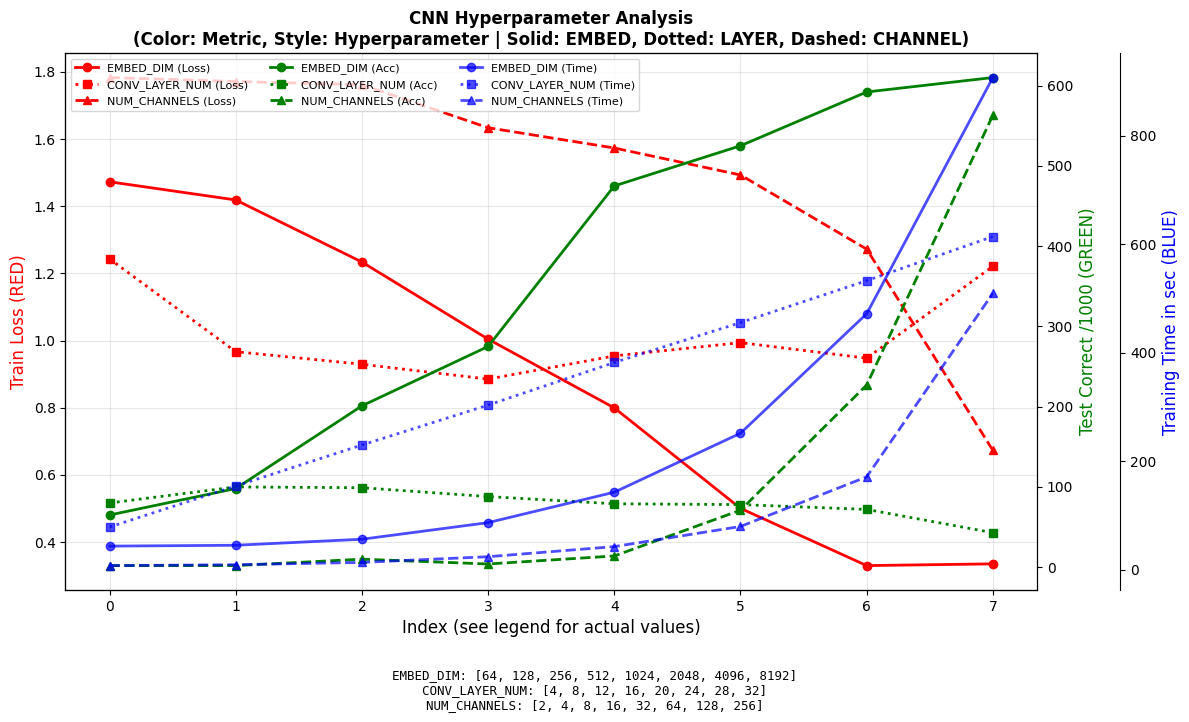

In [3]:
# ============================================================
# Plotting - Single Figure with 3 y-axes
# ============================================================
fig, ax1 = plt.subplots(figsize=(12, 7))

# Create additional y-axes
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))

# X-axis: use indices (0 to n-1)
n = len(embed_dims)
x_indices = list(range(n))

# Plot Train Loss (RED) - Left y-axis
# Solid: EMBED_DIM, Dotted: CONV_LAYER_NUM, Dashed: NUM_CHANNELS
l1 = ax1.plot(x_indices, losses_embed, 'r-o', linewidth=2, markersize=6, label='EMBED_DIM (Loss)')
l2 = ax1.plot(x_indices, losses_conv, 'r:s', linewidth=2, markersize=6, label='CONV_LAYER_NUM (Loss)')
l3 = ax1.plot(x_indices, losses_channels, 'r--^', linewidth=2, markersize=6, label='NUM_CHANNELS (Loss)')

# Plot Test Accuracy (GREEN) - Right y-axis 1
l4 = ax2.plot(x_indices, accs_embed, 'g-o', linewidth=2, markersize=6, label='EMBED_DIM (Acc)')
l5 = ax2.plot(x_indices, accs_conv, 'g:s', linewidth=2, markersize=6, label='CONV_LAYER_NUM (Acc)')
l6 = ax2.plot(x_indices, accs_channels, 'g--^', linewidth=2, markersize=6, label='NUM_CHANNELS (Acc)')

# Plot Training Time (BLUE) - Right y-axis 2
l7 = ax3.plot(x_indices, times_embed, 'b-o', linewidth=2, markersize=6, alpha=0.7, label='EMBED_DIM (Time)')
l8 = ax3.plot(x_indices, times_conv, 'b:s', linewidth=2, markersize=6, alpha=0.7, label='CONV_LAYER_NUM (Time)')
l9 = ax3.plot(x_indices, times_channels, 'b--^', linewidth=2, markersize=6, alpha=0.7, label='NUM_CHANNELS (Time)')

# Labels
ax1.set_xlabel('Index (see legend for actual values)', fontsize=12)
ax1.set_ylabel('Train Loss (RED)', fontsize=12, color='red')
ax2.set_ylabel('Test Correct /1000 (GREEN)', fontsize=12, color='green')
ax3.set_ylabel('Training Time in sec (BLUE)', fontsize=12, color='blue')

# Set x-axis ticks
ax1.set_xticks(x_indices)
ax1.set_xticklabels([f'{i}' for i in x_indices])

# Add text annotation for actual values
embed_str   = f"EMBED_DIM: {embed_dims}"
conv_str    = f"CONV_LAYER_NUM: {conv_layers}"
channel_str = f"NUM_CHANNELS: {num_channels_list}"
fig.text(0.5, -0.02, f"{embed_str}\n{conv_str}\n{channel_str}", 
         ha='center', fontsize=9, family='monospace')

# Combine legends
lines  = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8 + l9
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', fontsize=8, ncol=3)

ax1.grid(True, alpha=0.3)
plt.title('CNN Hyperparameter Analysis\n(Color: Metric, Style: Hyperparameter | Solid: EMBED, Dotted: LAYER, Dashed: CHANNEL)', 
          fontsize=12, fontweight='bold')
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## 3.2. SOTA model analysis

In [5]:
for num11 in range(10):
    for num12 in range(10):
        for num21 in range(10):
            for num22 in range(10):
                print(num11, num12, num21, num22)

0 0 0 0
0 0 0 1
0 0 0 2
0 0 0 3
0 0 0 4
0 0 0 5
0 0 0 6
0 0 0 7
0 0 0 8
0 0 0 9
0 0 1 0
0 0 1 1
0 0 1 2
0 0 1 3
0 0 1 4
0 0 1 5
0 0 1 6
0 0 1 7
0 0 1 8
0 0 1 9
0 0 2 0
0 0 2 1
0 0 2 2
0 0 2 3
0 0 2 4
0 0 2 5
0 0 2 6
0 0 2 7
0 0 2 8
0 0 2 9
0 0 3 0
0 0 3 1
0 0 3 2
0 0 3 3
0 0 3 4
0 0 3 5
0 0 3 6
0 0 3 7
0 0 3 8
0 0 3 9
0 0 4 0
0 0 4 1
0 0 4 2
0 0 4 3
0 0 4 4
0 0 4 5
0 0 4 6
0 0 4 7
0 0 4 8
0 0 4 9
0 0 5 0
0 0 5 1
0 0 5 2
0 0 5 3
0 0 5 4
0 0 5 5
0 0 5 6
0 0 5 7
0 0 5 8
0 0 5 9
0 0 6 0
0 0 6 1
0 0 6 2
0 0 6 3
0 0 6 4
0 0 6 5
0 0 6 6
0 0 6 7
0 0 6 8
0 0 6 9
0 0 7 0
0 0 7 1
0 0 7 2
0 0 7 3
0 0 7 4
0 0 7 5
0 0 7 6
0 0 7 7
0 0 7 8
0 0 7 9
0 0 8 0
0 0 8 1
0 0 8 2
0 0 8 3
0 0 8 4
0 0 8 5
0 0 8 6
0 0 8 7
0 0 8 8
0 0 8 9
0 0 9 0
0 0 9 1
0 0 9 2
0 0 9 3
0 0 9 4
0 0 9 5
0 0 9 6
0 0 9 7
0 0 9 8
0 0 9 9
0 1 0 0
0 1 0 1
0 1 0 2
0 1 0 3
0 1 0 4
0 1 0 5
0 1 0 6
0 1 0 7
0 1 0 8
0 1 0 9
0 1 1 0
0 1 1 1
0 1 1 2
0 1 1 3
0 1 1 4
0 1 1 5
0 1 1 6
0 1 1 7
0 1 1 8
0 1 1 9
0 1 2 0
0 1 2 1
0 1 2 2
0 1 2 3
0 1 2 4
